## Model Evaluation & Validation
## Predicting Boston Housing Prices


## Getting Started
In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.


In [9]:
# Adding shared path for visuals package import 
import os
import sys
module_path = os.path.abspath(os.path.join('work/shared'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
# Import libraries necessary for this project
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('~/work/shared/housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics

In [12]:
np.amin(prices)

105000.0

In [13]:
# Minimum price of the data
minimum_price = np.amin(prices)

# Maximum price of the data
maximum_price = np.amax(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105000.0
Maximum price: $1024800.0
Mean price: $454342.9447852761
Median price $438900.0
Standard deviation of prices: $165171.13154429474


## Feature Observation

As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

----

## Developing a Model

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you I ill be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify the model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

In [14]:
# Import 'r2_score'

from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Implementation: Shuffle and Split Data
For the next implementation it is required to take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In [15]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state = 42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Training and Testing

You may ask now:

* What is the benefit of splitting a dataset into some ratio of training and testing subsets for a learning algorithm?

It is useful to evaluate our model once it is trained. We want to know if it has learned properly from a training split of the data. There can be 3 different situations:

1) The model didn´t learn well from the data, and can't predict the outcomes of the training set within a reasonable range, this is called underfitting and it is caused because a high bias.

2) The model learns too well the training data, up to the point that it memorized it and is not able to generalize on new data, this is called overfitting, it is caused because of high variance.

3) The model has the right balance between bias and variance, it learns well and is able to predict the outcome on new data.

----

## Analyzing Model Performance
In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, we'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing the model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

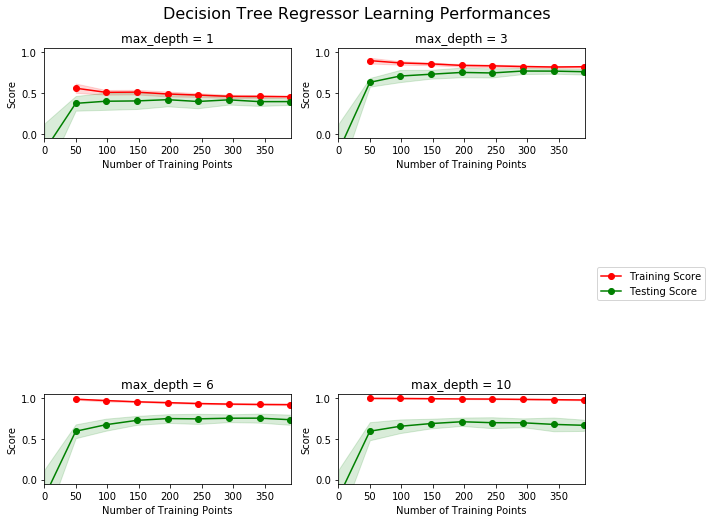

In [16]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Learning the Data

If we take a close look at the graph with the max depth of 3:

- As the number of training points increases, the training score decreases. In contrast, the test score increases.

- As both scores (training and testing) tend to converge, from the 300 points treshold, having more training points will not benefit the model.

- (Extra question): In general, with more columns for each observation, we'll get more information and the model will be able to learn better from the dataset and therefore, make better predictions.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

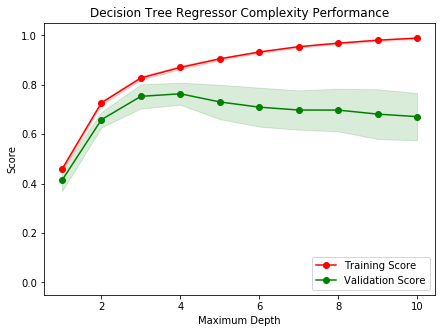

In [17]:
vs.ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff

If we analize how the bias-variance vary with the maximun depth, we can infer that:

- With the maximun depth of one, the graphic shows that the model does not return good score in neither training nor testing data, which is a symptom of underfitting and so, high bias. To improve performance, we should increase model's complexity, in this case increasing the max_depth hyperparameter to get better results.

- With the maximun depth of ten, the graphic shows that the model learn perfectly well from training data (with a score close to one) and also returns poor results on test data, which is an indicator of overfitting, not being able to generalize well on new data. This is a problem of High Variance. To improve performance, we should decrease the model's complexity, in this case decreasing the max_depth hyperparameter to get better results.

### Best-Guess Optimal Model

From the complexity curve, we can infer that the best maximum depth for the model is 4, as it is the one that yields the best validation score.

In addition, for more depth although the training score increases, validation score tends to decrease which is a sign of overfitting.

-----

## Evaluating Model Performance
In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Grid Search
* What is the grid search technique?
* How it can be applied to optimize a learning algorithm?

The grid search technique exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter, which is a dictionary with the values of the hyperparameters to evaluate. One eample can be:

param_grid =  [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
 
In this example, two grids should be explored: one with a linear kernel an C values of [1,10,100,1000], and the second one with an RBF kernel, and the cross product of C values ranging in [1, 10, 100, 1000] and gamma values in [0.001, 0.0001].

When fitting it on a dataset all the possible combinations of parameter values are evaluated and the best combination is retained.

### Cross-Validation

* What is the k-fold cross-validation training technique? 

* What benefit does this technique provide for grid search when optimizing a model?

K-fold cross-validation is a technique used for making sure that our model is well trained, without using the test set. It consist in splitting data into k partitions of equal size. For each partition i, we train the model on the remaining k-1 parameters and evaluate it on partition i. The final score is the average of the K scores obtained.

When evaluating different hyperparameters for estimators, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets (training, validating and testing sets), we drastically reduce the number of samples which can be used for learning the model, and the resulting model may not be sufficiently well trained (underfitting).

By using k-fold validation we make sure that the model uses all the training data available for tunning the model, it can be computationally expensive but allows to train models even if little data is available.

The main purpose of k-fold validation is to get an unbiased estimate of model generalization on new data.

### Implementation: Fitting a Model
The final implementation requires that we bring everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, we will find your implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*.


In [18]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. We can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Optimal Model

* What maximum depth does the optimal model have? 

In [19]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


### Predicting Selling Prices
Imagine that we were a real estate agent in the Boston area looking to use this model to help price homes owned by our clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would we recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

In [20]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


**Answer: **

The predicted selling prices are:

- For Client 1's home: $403,025.00

- For Client 2's home: $237,478.72

- For Client 3's home: $931,636.36

From question 1, we obtained the following statistics:

- Minimum price: $105000.0

- Maximum price: $1024800.0

- Mean price: $454342.9447852761

- Median price $438900.0

- Standard deviation of prices: $165340.27765266786

Given this values, we can conclude:

- Selling price for client 3 is near the million dollars, which is near the maximum of the dataset. This is a reasonable price because of its features (8 rooms, very low poverty level and low student-teacher ratio), the house may be in a wealthy neighborhood.

- Selling price for client 2 is the lowest of the three and given its features is reasonable as it is near the minimum of the dataset.

- For client 1, we can see that its features are intermediate between the latter 2, and therefore, its price is quite near the mean and median.

As stated on Question 1:

- 'RM', has a directy proportional relationship with the dependent variable 'Prices'.
- In contrast, 'LSTAT' and 'PTRATIO' have a inversely proportional relationship with the dependent variable 'PRICES'.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**The code cell below run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**

In [21]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


### Applicability

Now, we use these results to discuss whether the constructed model should or should not be used in a real-world setting. Some questions that are worth to answer: 

- How relevant today is data that was collected from 1978? How important is inflation?
- Are the features present in the data sufficient to describe a home? Do you think factors like quality of apppliances in the home, square feet of the plot area, presence of pool or not etc should factor in?
- Is the model robust enough to make consistent predictions?
- Would data collected in an urban city like Boston be applicable in a rural city?
- Is it fair to judge the price of an individual home based on the characteristics of the entire neighborhood?

**Answer: **

We obtained a range in prices of nearly 70k$, I believe that this is a quite large deviation as it represents approximately a 17% of the median value of house prices. Because of this, the model should not be used in a real world setting.

- Data collected from 1978 is not of much value in today's world, society and economics have changed so much and in addtion, inflation has made a great impact on the prices.

- The dataset considered is quite limited, there are a lot of features like the size of the house in square feet, the presence of pool or not and others, that are very relevant when considering a house price.

- Given the high variance on the prince range, we can assure that it is not a robust model and, therefore, not appropiate for making predictions.

- Data collected from a big urban city like Boston would not be applicable in a rural city, as for equal value of feaures prices are much higher in the urban area.

- In general it is not fair to estimate or predict the price of an indivual home based on the features of the entire neighborhood. In the same neighborhood there can be huge differences in prices.